In [1]:
import sys
import os

In [2]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

In [3]:
import mysql.connector
from mysql.connector.cursor import MySQLCursor

In [4]:
import pandas

In [5]:
sys.path.append(os.path.join(os.path.abspath(os.path.join('../..')), 'src'))

In [6]:
import utils

## Query Data from MySQL

In [6]:
cnx = mysql.connector.connect(user='immersinn', password='pass01', database='articles')

In [7]:
cur = MySQLCursor(cnx)

In [8]:
fields = ['link', 'title', 'rss_link', 'summary', 'published']

In [9]:
date_query_base = '''SELECT ''' + \
                      ', '.join(fields) + \
                      ''' FROM rssfeed_links WHERE published BETWEEN %s AND %s'''
date_query_base

'SELECT link, title, rss_link, summary, published FROM rssfeed_links WHERE published BETWEEN %s AND %s'

In [10]:
cur.execute(date_query_base, ('2017-02-1 00:00:00', '2017-02-02 00:00:00'))

In [11]:
records = cur.fetchall()

In [12]:
len(records)

321

In [13]:
cols = cur.column_names

In [14]:
cnx.close()

## Build DF from Queried Data

In [15]:
df = pandas.DataFrame(data = records, columns=cols)

In [16]:
# Filter out duplicates?
unique_entries = []
titles = set()
for i in df.index:
    if df.ix[i].title not in titles:
        unique_entries.append(i)
        titles.update([df.ix[i].title])
        
df = df.ix[unique_entries]
df.index = range(df.shape[0])

In [17]:
df.shape

(282, 5)

In [18]:
df.head()

,link,title,rss_link,summary,published
0,http://feedproxy.google.com/~r/breitbart/~3/yW...,Judge Rules Video Game Publisher 2K Games Owns...,http://feeds.feedburner.com/breitbart?format=xml,"<a href=""http://www.breitbart.com/tech/2017/02...",2017-02-01 22:07:39
1,http://feeds.foxnews.com/~r/foxnews/internal/t...,Cruise lines weigh in on potential impact of P...,http://feeds.foxnews.com/foxnews/internal/trav...,Will the executive order impact your planned c...,2017-02-01 19:15:00
2,http://feeds.foxnews.com/~r/foxnews/most-popul...,War of words: California Governor Brown takes ...,http://feeds.foxnews.com/foxnews/most-popular,Strategy Room: Christopher Hale and Kevin McCu...,2017-02-01 18:31:01
3,http://podcasts.cnn.net/cnn/big/studentnews/20...,CNN10 - 02/02/17,http://rss.cnn.com/services/podcasting/student...,"The U.S. Supreme Court nomination process, the...",2017-02-01 23:35:38
4,http://www.bbc.co.uk/news/38816782,'I don't belong here',http://feeds.bbci.co.uk/news/education/rss.xml,"Iranian, Iraqi, Syrian and Pakistani students ...",2017-02-01 00:04:55


## Basic Event Grouping with JM Smoothing

### Build the Feature to Use

In [ ]:
import textacy

In [ ]:
textacy_preprocessor = lambda text: textacy.preprocess.preprocess_text(text, 
                                                                       no_punct=True,
                                                                       no_contractions=True,
                                                                       no_numbers=True,
                                                                       no_emails=True,
                                                                       no_currency_symbols=True)

In [19]:
# need to remove the stopwords becauuse the corpus is comprised of short phrases,
# and stopwords are not prominent enough to obtain a significant depreciated
# weighting....
nltk_stops = set(
    ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']
)


# Simple "processing"; only using the title at the moment,
# no summary (seems to work pretty well....)
def extractHTMLText(summary):
    return(bs(summary, 'html.parser').text.strip())

def process_summary(summary):
    summary = extractHTMLText(summary)
    summary = summary.lower()
    return(summary)

def build_text_feature(doc):
    #summary = process_summary(doc['summary'])
    summary = ""
    title = doc['title'].lower()
    feature = title + ' ' + summary
    feature = ' '.join([w for w in feature.split() if w not in nltk_stops])
    #feature = textacy_preprocessor(feature).strip().strip('\t')
    return(feature)

In [20]:
df['text_feature'] = [build_text_feature(df.ix[i]) for i in df.index]

In [21]:
df['text_feature'][:10]

0    judge rules video game publisher 2k games owns...
1    cruise lines weigh potential impact president ...
2     war words: california governor brown takes trump
3                                     cnn10 - 02/02/17
4                                'i don't belong here'
5       lego film boosts paisley's uk city culture bid
6          german bakery's trump slices divide opinion
7                                   employment warning
8                            'we must stay optimistic'
9         apple: iphone 7 helps us giant return growth
Name: text_feature, dtype: object

### JM Smoothing Method

In [26]:
import numpy
from scipy import spatial

In [23]:
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
# Count vec titles with sklearn
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df.text_feature)

#### Calc JM Doc vecs

In [27]:
# Build necessary elements for JM
doc_lengths = numpy.array(X_train_counts.sum(axis=1)).reshape((X_train_counts.shape[0],1))
word_doc_freqs = numpy.array(
                            (X_train_counts > 0).sum(axis=0) / X_train_counts.shape[0]
                            ).reshape((X_train_counts.shape[1],1))
word_probs = numpy.array(X_train_counts.sum(axis=0) / X_train_counts.sum()).reshape((X_train_counts.shape[1],1))

In [28]:
lam = 0.1

In [29]:
weighted_doc_vecs = numpy.log(1 + (1-lam) / lam * X_train_counts / numpy.dot(doc_lengths, word_probs.T))

#### Calc Pairwise-Scores for Docs, Standardize

In [30]:
doc_doc_scores = spatial.distance.cdist(X_train_counts.todense(), 
                                              weighted_doc_vecs,
                                              numpy.dot)

In [31]:
doc_doc_scores -= numpy.diag(doc_doc_scores.diagonal())

In [32]:
doc_doc_scores /= doc_doc_scores.max()

### Analysis

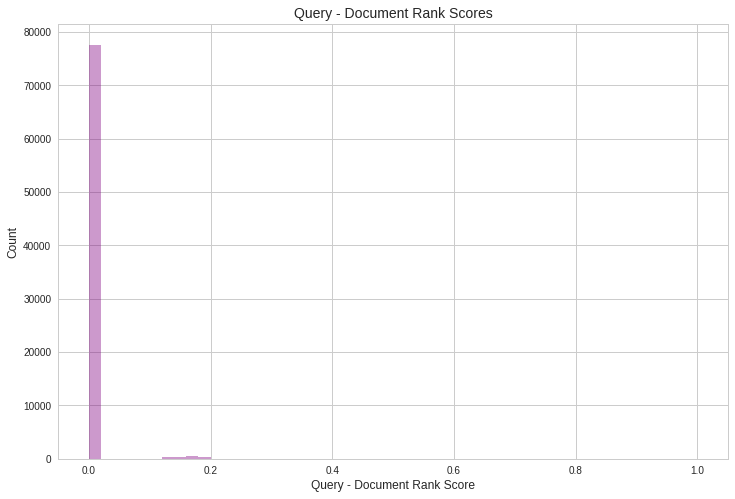

In [33]:
g = sns.distplot(doc_doc_scores.flatten(), kde=False, color='purple');
g.figure.set_size_inches(12,8);
plt.title("Query - Document Rank Scores", size=14);
plt.xlabel("Query - Document Rank Score", size=12);
plt.ylabel("Count", size=12);

In [34]:
pandas.Series(doc_doc_scores.flatten()).describe([0.25, 0.5, 0.9, 0.95, 0.99])

count    79524.000000
mean         0.004185
std          0.029175
min          0.000000
25%          0.000000
50%          0.000000
90%          0.000000
95%          0.000000
99%          0.172327
max          1.000000
dtype: float64

### Find "Connected Components" / Article Event Groups

In [35]:
hits = numpy.where(doc_doc_scores > 0.5)

In [36]:
## Need to find all "groups" of articles; how?
unique_nodes = set()
unique_nodes.update(set(hits[0]))
unique_nodes.update(set(hits[1]))

##
visited = set()
connected_components = list()

for node in unique_nodes:
    
    if node not in visited:
        ccc = set([node])
        to_visit = set([node])
        
        while to_visit:
            node = to_visit.pop()
            visited.update([node])
            
            # Find all instances of node
            h0_find = numpy.where(hits[0]==node)
            h1_find = numpy.where(hits[1]==node)

            # Get compliments of node
            h0_newnodes = set(hits[1][h0_find])
            h1_newnodes = set(hits[0][h1_find])

            # Update the current connected component
            ccc.update(h0_newnodes)
            ccc.update(h1_newnodes)

            # Update the "to visit" list while avoiding
            # "forever" loops...
            to_visit.update(h0_newnodes.difference(visited))
            to_visit.update(h1_newnodes.difference(visited))
            
        connected_components.append(ccc)

In [37]:
len(connected_components)

11

In [38]:
def compare_entries_v2(cc):
    
    def print_doc_stats(i):
        doc = df.ix[i]
        print(doc.published)
        print(doc.rss_link)
        print(doc.text_feature)
        
    for node in cc:
        print_doc_stats(node)
        print('\n')

In [39]:
for cc in connected_components:
    compare_entries_v2(cc)
    print('\n')

2017-02-01 02:58:29
https://www.theguardian.com/us/environment/rss
dakota access pipeline moves final stage army corps approval process


2017-02-01 16:01:16
http://feeds.bbci.co.uk/news/science_and_environment/rss.xml
dakota pipeline: us army allow work final section




2017-02-01 02:45:35
https://www.theguardian.com/us/business/rss
chinese billionaire xiao jianhua 'abducted' hong kong hotel


2017-02-01 02:44:33
http://www.ft.com/rss/world/asia-pacific/china
chinese billionaire abducted hong kong




2017-02-01 01:00:02
http://phys.org/rss-feed/
tuberculosis-resistant cows developed first time using crispr technology


2017-02-01 01:05:48
http://feeds.bbci.co.uk/news/science_and_environment/rss.xml
'tuberculosis-resistant' cattle developed china




2017-02-01 06:48:52
https://www.theguardian.com/us/business/rss
japan rejects trump accusation devaluing yen currency war


2017-02-01 08:08:56
http://www.ft.com/rss/world/asia-pacific/japan
japan rejects trump’s yen manipulation charge
